In [1]:
from torch import nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from dlc_practical_prologue import generate_pair_sets

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(128, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(x)
        
        x = self.fc1(x.view(-1, 128))
        x = nn.functional.relu(x)

        x = self.fc2(x)

        return x

In [3]:
def train(train_x, train_y, model, criterion, optimizer, epoch, batch_size):
    acc_loss = 0
    acc_acc = 0
    model.train()

    i = 0

    for b in range(batch_size):
        batch = min(b+batch_size, train_x.size(0))
        batch_x, batch_y = train_x.narrow(0, b, batch), train_y.narrow(0, b, batch)

        out = model(batch_x)
        loss = criterion(out, batch_y)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        acc_loss += loss.item()
        acc_acc += accuracy(out, batch_y)
        i += 1

    return acc_loss / i, acc_acc / i


In [4]:
def validate(val_x, val_y, model, criterion, e, batch_size):
    acc_loss = 0
    acc_acc = 0
    model.eval()
    i = 0
    for b in range(batch_size):
        batch = min(b+batch_size, val_x.size(0))
        batch_x, batch_y = val_x.narrow(0, b, batch), val_y.narrow(0, b, batch)

        with torch.no_grad():
            out = model(batch_x)
            loss = criterion(out, batch_y)

            acc_loss += loss
            
            acc_acc += accuracy(out, batch_y)
        i += 1

    return acc_loss / i, acc_acc / i


In [5]:
def accuracy(out, target):
    out = out.argmax(dim=1)
    n_correct = (out == target).sum().item()
    return n_correct / target.size(0)

In [6]:

train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nb=1000)

In [21]:
n_epochs = 10
lenet = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for e in tqdm(range(n_epochs)):
    l, a = train(train_input, train_target, lenet, criterion, optimizer, e, 64)
    train_loss.append(l)
    train_acc.append(a)

    l, a = validate(test_input, test_target, lenet, criterion, e, 64)
    test_loss.append(l)
    test_acc.append(a)

100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


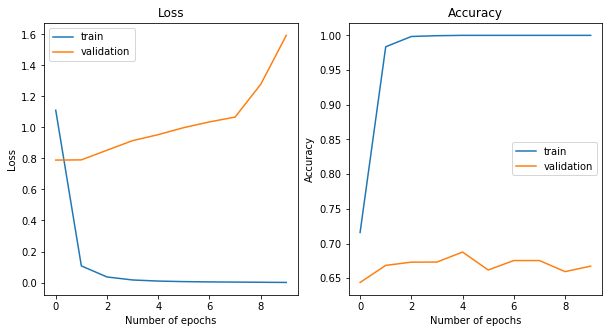

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.flatten()

# Plot loss
axes[0].plot(train_loss)
axes[0].plot(test_loss)
axes[0].set_title('Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Number of epochs')
axes[0].legend(['train', 'validation'])

# Plot accuracy
axes[1].plot(train_acc)
axes[1].plot(test_acc)
axes[1].set_title('Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Number of epochs')
axes[1].legend(['train', 'validation'])